# (MBTI) Myers-Briggs Personality Type

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, hamming_loss, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from collections import Counter
import re

sns.set()

In [2]:
data_source = pd.read_csv("mbti_1.csv")
data_source

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


## Introduction

MBTI is a personality test indicating preferences in how people perceive the world and make decisions. Its outcome is a four-letter test result, such as "INTJ" or "ENTP", where each letter represents one of four categories:
 - Introversion or Extraversion
 - Sensing or Intuition
 - Thinking or Feeling
 - Judging or Perceiving


### Dataset: Personality Cafe Forum
The origin of the dataset is in the [Personality Cafe Forum](https://www.personalitycafe.com/), where users discuss various psychological topics. Each user has to option to fill their MBTI type into their profile. This dataset is a collection of posts of such users that have their MBTI type made publicly available.

 - 8675 rows - one row per user
 - 2 columns:
   - **Type** - 4-letter MBTI code/type of the user
   - **Posts** - a section of the last 50 things the user has posted (separated by "|||")
     - they contain hypertext links, special characters, emojis


### Goal
Use ML algorithm to determine users's personality type based on language styles used in their posts online.

### Constants


In [3]:
random_state = 42

# comment count range per person (to remove samples with unexpected number of comments)
min_comments = 40
max_comments = 50

use_resampling = True
resampling_max_sample_count = 500
#resampling_sample_count_rank = 12 # [0-15], 0 => most frequent value, 15 => least frequent value

vocabulary_word_min_frequency = 5000

important_category_words_max_count = 1000 # max number of words per category to be included in the vocabulary of important words
important_category_words_min_frequency = 0.6 # min frequency of words per category to be included in the vocabulary of important words
discretizer_bin_count = 10 # count of bins in KBinsDiscretizer used in pipeline

# Decision Tree
decision_tree_max_depth = 12
decision_tree_min_samples_leaf = 5

# Random Forest
random_forest_max_depth = 25
random_forest_min_samples_leaf = 5
random_forest_n_estimators = 400

## Exploratory data analysis

For the purposes of exploratory data analysis and preprocessing, we did the following steps:
 - split the posts by "|||"
 - extract features such as the mean post length, emoji count, or hypertext link count
   - these features are also later used for training the model
 - created new column for each MBTI letter 
   - e.g., to be able to count the number of extroverts and introverts in our dataset

In [4]:
def split_comments(posts):
    return list(posts.split("|||"))

def join_comments(comments):
    return " ".join(comments)

def length_of_comment(comment):
    return len(comment.split(" "))

def count_links(comments):
    return sum(map(lambda c: c.count("http"), comments))

def count_comments_with_links(comments):
    return len(list(filter(lambda c: "http" in c, comments)))

def message_length(comments):
    return sum(map(lambda c: len(c.split(" ")), comments))

def remove_links(comments):
    return list(filter(lambda c: "http" not in c, comments))

def count_emoji(comments):
    emoji_regex = "(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)"
    return sum(map(lambda c: len(re.findall(emoji_regex, c)), comments))


# feature extraction to be used in the pipeline
def add_engineered_features(data):
    data = data.copy()
    data["comments"] = data.posts.apply(split_comments)
    data["n_comments"] = data.comments.apply(len)

    data["comments_without_links_joined_lower"] = data.comments.apply(remove_links).apply(join_comments).apply(str.lower)

    data["mean_comment_with_link_count"] = data.comments.apply(count_comments_with_links) / data.n_comments
    data["mean_link_count"] = data.comments.apply(count_links) / data.n_comments
    data["mean_msg_length"] = data.comments.apply(message_length) / data.n_comments
    data["mean_emoji_count"] = data.comments.apply(remove_links).apply(count_emoji) / data.n_comments

    return data


def extroverted(p):
    return 1 if p[0] == 'E' else 0
def sensing(p):
    return 1 if p[1] == 'S' else 0
def thinking(p):
    return 1 if p[2] == 'T' else 0
def judging(p):
    return 1 if p[3] == 'J' else 0


def split_mbti_type(data):
    data = data.copy()
    data["extroverted"] = data.type.apply(extroverted)
    data["sensing"] = data.type.apply(sensing)
    data["thinking"] = data.type.apply(thinking)
    data["judging"] = data.type.apply(judging)
    return data


def filter_valid_n_comments(data):
    data_n_comments = data.posts.apply(split_comments).apply(len)
    return data[(data_n_comments >= min_comments) & (data_n_comments <= max_comments)]

In [5]:
data_with_features = add_engineered_features(data_source)
data_with_features = split_mbti_type(data_with_features)

data_with_features

,type,posts,comments,n_comments,comments_without_links_joined_lower,mean_comment_with_link_count,mean_link_count,mean_msg_length,mean_emoji_count,extroverted,sensing,thinking,judging
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ...",50,what has been the most life-changing experienc...,0.42,0.48,12.54,0.06,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...,50,'i'm finding the lack of me in these posts ver...,0.14,0.20,24.86,0.32,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...,50,"of course, to which i say i know; that's my bl...",0.10,0.10,18.36,0.18,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ...",50,"'dear intp, i enjoyed our conversation the o...",0.04,0.04,23.00,0.00,0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce...",50,'you're fired. that's another silly misconcept...,0.12,0.12,20.72,0.04,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,"['https://www.youtube.com/watch?v=t8edHB_h908,...",50,especially on websites that have become a have...,0.14,0.14,17.30,0.10,0,1,0,0
8671,ENFP,'So...if this thread already exists someplace ...,['So...if this thread already exists someplace...,50,ooops...i guess i didn't look too hard because...,0.04,0.04,28.86,0.44,1,0,0,0
8672,INTP,'So many questions when i do these things. I ...,['So many questions when i do these things. I...,50,'so many questions when i do these things. i ...,0.04,0.04,21.02,0.00,0,0,1,0
8673,INFP,'I am very conflicted right now when it comes ...,['I am very conflicted right now when it comes...,50,'i am very conflicted right now when it comes ...,0.00,0.00,36.60,0.00,0,0,0,0


### Class Imbalance

The number of samples for some MBTI types vastly differs from the other type samples. We will address this class imbalance in preprocessing phase by undersampling our data.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


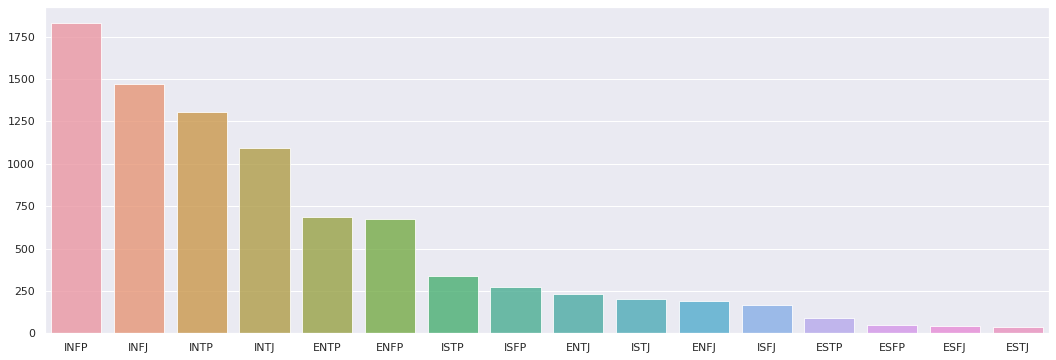

In [6]:
def plot_value_counts(data):
    val_counts = data.value_counts()

    plt.figure(figsize=(18,6))
    sns.barplot(val_counts.index, val_counts.values, alpha=0.8)

plot_value_counts(data_source.type)

### MBTI category representation

Another view on class imbalance in our dataset. From the plots below we can see that we have much more samples from introverted or intuitive users than from extroverted or sensing ones. Thinking and judging classes seem to be more equally represented.

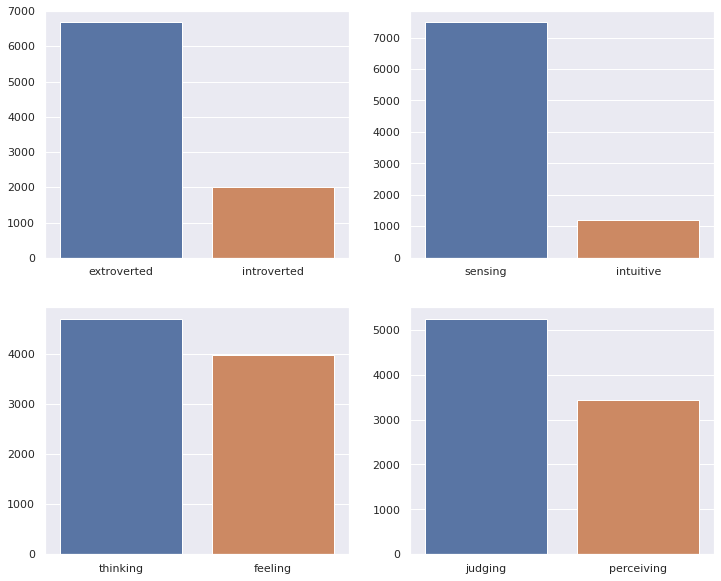

In [7]:
mbti_features = [("extroverted", "introverted"), ("sensing", "intuitive"), ("thinking", "feeling"), ("judging", "perceiving")]

fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax = ax.flatten()
for (i, feature) in enumerate(mbti_features):
    val_counts = data_with_features[feature[0]].value_counts()
    sns.barplot(x=[feature[0], feature[1]], y=val_counts.values, ax=ax[i])

plt.show()

### Mean message lengths

Introverts tend to write longer posts.

<AxesSubplot:xlabel='type', ylabel='mean_msg_length'>

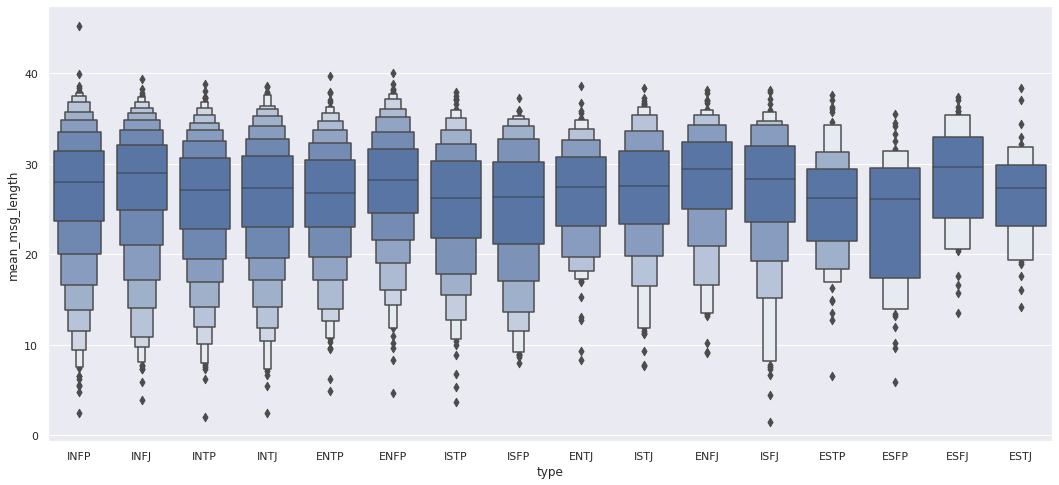

In [8]:
val_counts = data_with_features.type.value_counts()

plt.figure(figsize=(18,8))
sns.boxenplot(color="b", scale="linear", x="type", y="mean_msg_length", data=data_with_features, order=val_counts.index)

### Emoji count

As expected, extroverts use more emojis.

<AxesSubplot:xlabel='type', ylabel='mean_emoji_count'>

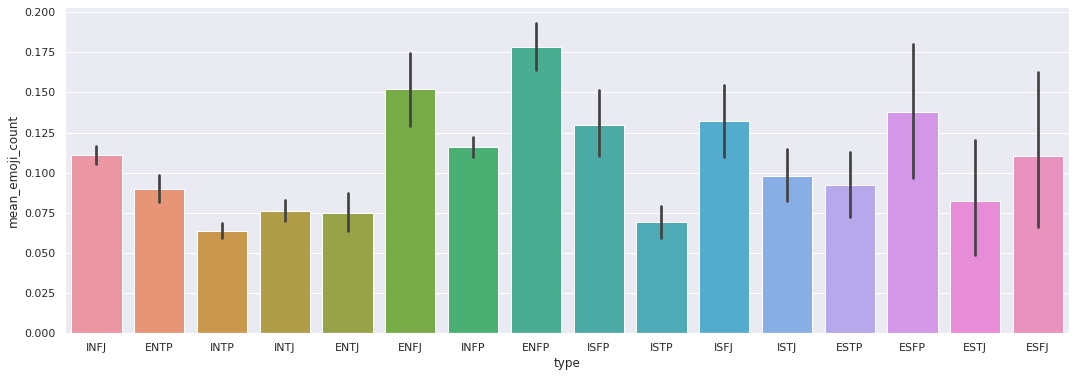

In [9]:
plt.figure(figsize=(18,6))
sns.barplot(x="type", y="mean_emoji_count", data=data_with_features)

## Preprocessing

 1. Throw away samples with invalid number of comments.
 2. Undersample types with the most samples to avoid overfitting on these types.
 3. Create a vocabulary of the most important words.
 4. Split the data into train, validation, and test sets.

### Filter out invalid number of comments

The dataset description states that there are 50 comments per person, which is not always the case. We therefore throw away samples that have the number of comments not lying in interval [40, 50].

In [10]:
data_with_features = filter_valid_n_comments(data_with_features)
data = filter_valid_n_comments(data_source)

### Undersampling

We define a threshold of the maximum sample count and undersample those MBTI types that have more samples than this threshold. MBTI types with a lower sample count are left untouched.

It's not possible to balance the classes evenly, because we wouldn't have enough data. We can't also use oversampling because it would lead to overfitting on the underrepresented classes.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


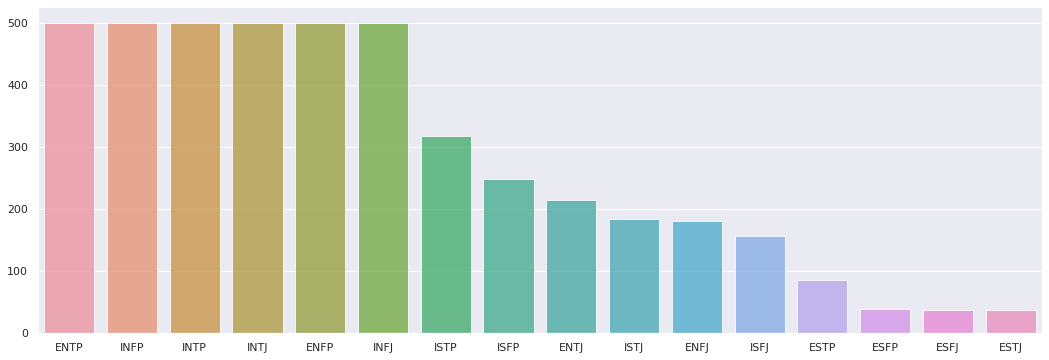

In [11]:
def undersample(data):
    type_counts = data.type.value_counts()
    
    df = []
    for category in type_counts.index:
        category_types = data.type[data.type == category]
        category_posts = data.posts[data.type == category]

        current_category_size = len(category_types)

        # prevent oversampling
        if resampling_max_sample_count >= current_category_size:
            df = df + list(zip(category_types, category_posts))
            continue

        type_resampled, posts_resampled = resample(
            category_types,
            category_posts,
            replace=True,
            n_samples=resampling_max_sample_count,
            random_state=random_state
        )
        df = df + list(zip(type_resampled, posts_resampled))
    
    return pd.DataFrame.from_records(df, columns=["type", "posts"])

data_resampled = undersample(data_with_features)

plot_value_counts(data_resampled.type)

if use_resampling:
    data = data_resampled

### Train test split
The whole data set is split into a train, validation and test set. The test set is not even looked upon until the very end.

In [12]:
# data splitting function
def split_label(data):
    return (data.drop(columns=['type']), data.type)

train_data, test_data = train_test_split(data, test_size=0.2)
train_data, validation_data = train_test_split(train_data, test_size=0.2)
MBTI_train_X, MBTI_train_y = split_label(train_data)
MBTI_validation_X, MBTI_validation_y = split_label(validation_data)
MBTI_test_X, MBTI_test_y = split_label(test_data)

train_data_with_features = split_mbti_type(add_engineered_features(train_data))

### Word analysis
During exploratory analysis we wanted to find words typical for different personalities. The following code finds words which are used mostly by people of a single personality trait. For example introverts often talk about their personal struggles while extroverts talk about partying and drinking beer.

Only words with more than **5000** occurences are selected. The words are selected from the train dataset, therefore no data leakage is possible. The frequencies of word per personality class are relearned by the model.

Some personalities often use their MBTI codes which may sometimes easily identify them. We've decided not to remove such comments as they are a natural part of conversation on Personality Cafe.

In [13]:
def count_words(data, vocab=None):
    counter = Counter()
    
    for comments in data:
        for word in comments.split(' '):
            if not vocab or word in vocab:
                counter[word] += 1
    
    return counter


def get_vocabulary(data):
    counter = count_words(data)
    return set(map(lambda x: x[0], counter.most_common(vocabulary_word_min_frequency)))


def relative_usage(c0, c1, p_cat0, p_cat1):
    c0 = c0 / p_cat0
    c1 = c1 / p_cat1
    return c0 / (c0 + c1)


def most_used_words(data, category, vocab):
    (cat0, cat1) = data[category].value_counts().values
    p_cat0 = cat0 / (cat0 + cat1)
    p_cat1 = 1 - p_cat0

    cat0_counter = count_words(data[data[category] == 0].comments_without_links_joined_lower, vocab)
    cat1_counter = count_words(data[data[category] == 1].comments_without_links_joined_lower, vocab)
        
    cat0_usage = dict()
    cat1_usage = dict()
    for word in vocab:
        usage = relative_usage(cat0_counter[word], cat1_counter[word], p_cat0, p_cat1)
        cat0_usage[word] = usage
        cat1_usage[word] = 1 - usage

    return (cat0_usage, cat1_usage)


def is_legit_word(word):
    return word.isalpha() and len(word) > 2

In [14]:
vocab = get_vocabulary(train_data_with_features.comments_without_links_joined_lower)

# get most used words per category
(introverted_words, extroverted_words) = most_used_words(train_data_with_features, "extroverted", vocab)
(intuitive_words, sensing_words) = most_used_words(train_data_with_features, "sensing", vocab)
(feeling_words, thinking_words) = most_used_words(train_data_with_features, "thinking", vocab)
(perceiving_words, judging_words) = most_used_words(train_data_with_features, "judging", vocab)

# print most frequent words per category
for (words, heading) in [
        (introverted_words, "Introverted"), (extroverted_words, "Extroverted"),
        (intuitive_words, "Intuitive"), (sensing_words, "Sensing"),
        (feeling_words, "Feeling"), (thinking_words, "Thinking"), 
        (perceiving_words, "Perceiving"), (judging_words, "Judging")]:
    print(heading)
    word_df = pd.DataFrame.from_records([(w, e) for w, e in words.items() if is_legit_word(w)], columns=['word', 'usage'])
    print(word_df.sort_values('usage', ascending=False).head(10))
    print()

# get important words
important_words = set()
for category_words in [
        introverted_words, extroverted_words, 
        intuitive_words, sensing_words,
        feeling_words, thinking_words, 
        perceiving_words, judging_words]:
    
    sorted_category_words = sorted(category_words.items(), key=lambda item: -item[1])
    important_legit_category_words = list(filter(lambda w: is_legit_word(w[0]) and w[1] >= important_category_words_min_frequency, sorted_category_words))
    important_legit_category_words = important_legit_category_words[:important_category_words_max_count]
    
    for word in important_legit_category_words:
        important_words.add(word[0])

Introverted
           word     usage
3039   movement  0.788596
1168      vivid  0.787232
2819      walls  0.783388
699         gen  0.772555
2233        gym  0.759641
1114     images  0.755704
3154  classical  0.754339
2164       harm  0.750151
1992       snow  0.738251
2320      lucid  0.736156

Extroverted
           word     usage
1076  inception  0.866574
2482      entps  0.860773
2017      enfps  0.836911
1805      entjs  0.827376
1522      estps  0.799738
1221       entp  0.787958
1487       entj  0.787729
2899      wasnt  0.780507
2759       enfp  0.780141
241       enfjs  0.768395

Intuitive
             word     usage
1076    inception  1.000000
3083     ignorant  0.872209
1847         cope  0.858250
3012       quoted  0.848813
625      humanity  0.842249
1579      romance  0.830156
1118    ignorance  0.829678
1619        stars  0.819527
1016         tall  0.816797
3044  realization  0.816797

Sensing
         word     usage
311     isfjs  0.854678
1217    istps  0.839559
131

## Models

In this section we are training and evaluating several models. The model predicts all traits at once.

Here, we specify our continuous and label features.

In [15]:
continuous_features = [ 
    'mean_comment_with_link_count',
    'mean_link_count',
    'mean_msg_length',
    'mean_emoji_count'
]

label_features = ['type']

For evaluation, we are using **F1 score** because it punishes incorrect predictions in under-represented classes (unlike for example accuracy).

Another metric we are using is the **Hamming distance** between the true and the predicted class. We want to distinguish between the case when the predicted class is wrong by only one letter (better case) or all 4 letters (worst case).

In [16]:
def plot_confusion_matrix(test_y, pred_y):
    sns.reset_orig()
    fig, ax = plt.subplots(figsize=(10,10))
    ConfusionMatrixDisplay.from_predictions(test_y, pred_y, ax=ax)
    sns.set()

def plot_trait_confusion_matrix(test_y, pred_y):
    sns.reset_orig()

    traits = [
        (['Introverted', 'Extroverted'], extroverted),
        (['Intuitive', 'Sensing'], sensing),
        (['Feeling', 'Thinking'], thinking),
        (['Perceiving', 'Judging'], judging),
    ]

    fig, ax = plt.subplots(2, 2, figsize=(12,10))
    ax = ax.flatten()
    for (i, trait) in enumerate(traits):
        test = list(map(trait[1], test_y))
        pred = list(map(trait[1], pred_y))
        ConfusionMatrixDisplay.from_predictions(test, pred, display_labels=trait[0], ax=ax[i], colorbar=False)
    
    sns.set()


def plot_hamming_distance(test_y, pred_y):
    test_extroverted = list(map(extroverted, test_y))
    test_sensing = list(map(sensing, test_y))
    test_thinking = list(map(thinking, test_y))
    test_judging = list(map(judging, test_y))
    pred_extroverted = list(map(extroverted, pred_y))
    pred_sensing = list(map(sensing, pred_y))
    pred_thinking = list(map(thinking, pred_y))
    pred_judging = list(map(judging, pred_y))
    
    test_matrix = np.c_[test_extroverted, test_sensing, test_thinking, test_judging]
    pred_matrix = np.c_[pred_extroverted, pred_sensing, pred_thinking, pred_judging]
    dist = np.sum(np.abs(test_matrix - pred_matrix), axis=1)

    mistakes = [0] * 5
    for i in range(5):
        mistakes[i] = list(dist).count(i) / len(dist)
    
    plt.figure(figsize=(10,5))
    plt.title("Frequency of incorrectly classified MBTI letters")
    plt.xlabel("Number of mismatched letters (Hamming distance of MBTI codes)")
    plt.ylabel("Frequency")
    ax = sns.barplot(list(range(5)), np.round(mistakes,3), alpha=0.8)
    ax.bar_label(ax.containers[0])


def evaluate_model(test_y, pred_y, average="micro", plot_trait_matrix=False):
    plot_hamming_distance(test_y, pred_y)
    
    plot_confusion_matrix(test_y, pred_y)

    if plot_trait_matrix:
        plot_trait_confusion_matrix(test_y, pred_y)

    print("F1 score:", f1_score(test_y, pred_y, average=average))

### Baseline model
Our baseline model predicts the most frequent class for all inputs, we have chosen this model since classes of personalities are unbalanced. For example there are more INFP than other types.

From the first plot we can immediately observe the poor performance of this model. Each column represents the respective number of letters that were incorrectly classified. For example, the first column shows that 10 % of cases were classified correctly, i.e., all letters were matching with ground truth. Similarly, the second column shows that 28 % of cases were classified almost correctly, having one letter mismatched.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
F1 score: 0.10555555555555556


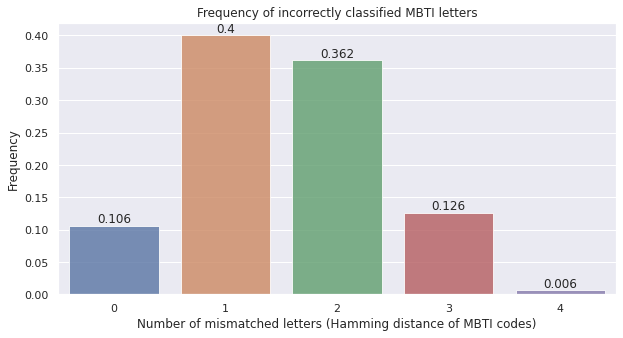

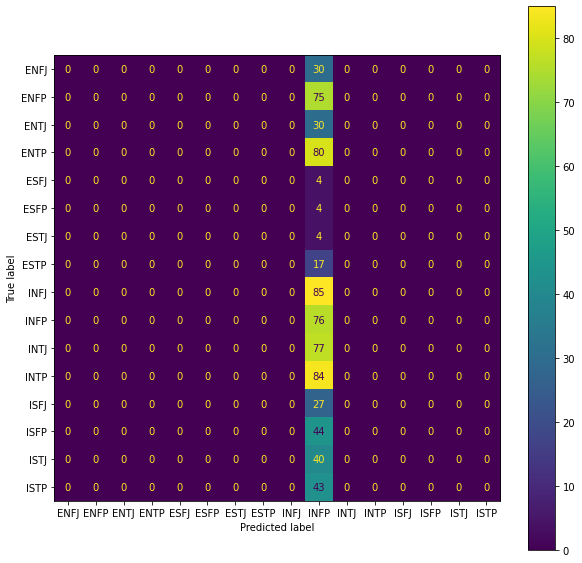

In [17]:
baseline_pipeline = make_pipeline(
    DummyClassifier(strategy="most_frequent")
)
baseline_pipeline.fit(MBTI_train_X, MBTI_train_y)

MBTI_pred_y = baseline_pipeline.predict(MBTI_validation_X)
evaluate_model(MBTI_validation_y, MBTI_pred_y, "micro")

### Descision tree

Other model that we have chosen is a descision tree classifier, because we want to predict discrete classes.The model recursively splits the training set into two groups based on feature that makes the groups as homogenous as posisble. The idea is, that some classes of people use different words, so they will be split into different branches. Here we want to limit the minimum number of samples per leaf so it is not too overfitted and we limit the depth of the tree for the same reason.

#### Model interpretation
This model will split people into groups based on how many and what words do they use. Model is very sensitive towards the words that one class uses more than the other. Model is also sensitive towards parameter min_samples_leaf, because it prevents overfitting in sense that if one person says one word a lot it will not label all people that use that word with his type. 

#### Model pipeline
* Extract new features using `FunctionTransformer` and `add_engineered_features`
* Count words in comments using `CountVectorizer`
* Classify the personality with Decision Tree

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
F1 score: 0.4722222222222222


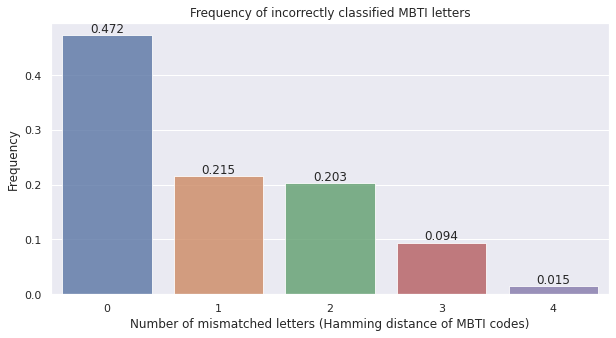

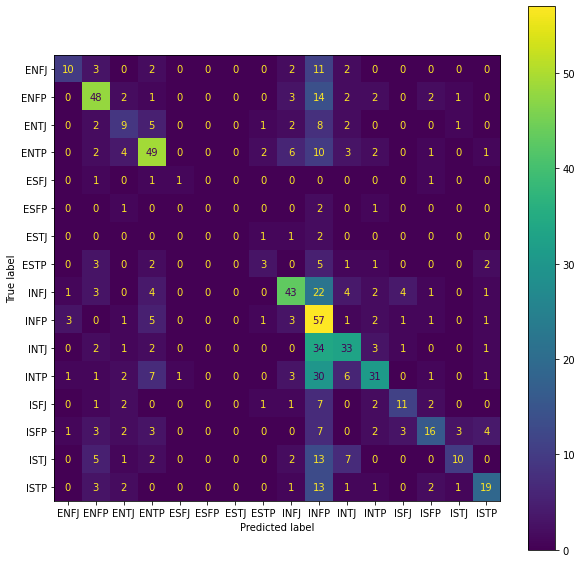

In [18]:
tree_pipeline = make_pipeline(
    FunctionTransformer(add_engineered_features),
    make_column_transformer(
        (CountVectorizer(vocabulary=important_words), 'comments_without_links_joined_lower'),
        ('passthrough', continuous_features),
        remainder='drop'),
    DecisionTreeClassifier(max_depth=decision_tree_max_depth, min_samples_leaf=decision_tree_min_samples_leaf)
)

tree_pipeline.fit(MBTI_train_X, MBTI_train_y)

MBTI_pred_y = tree_pipeline.predict(MBTI_validation_X)
evaluate_model(MBTI_validation_y, MBTI_pred_y, "micro")

### Random forest
Decision trees use imprefect heuristics when learning and therefore the fitted model may not be optimal. This issue can be tackled by using random forest which trains several trees. When predicting a class, the model decides based on the predictions of all the trained trees. Most parameters of the model are inherited from the Decision tree classifier.

#### Hyperparameter tuning
The most influential parameter was the vocabulary of the count vectorizer. It's not a part of the pipeline, so we couldn't use grid search and all parameters were tuned by hand. The model was also sensitive to parameters of the decision trees - most notably depth and minimal count of samples in leaves.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
F1 score: 0.6555555555555556


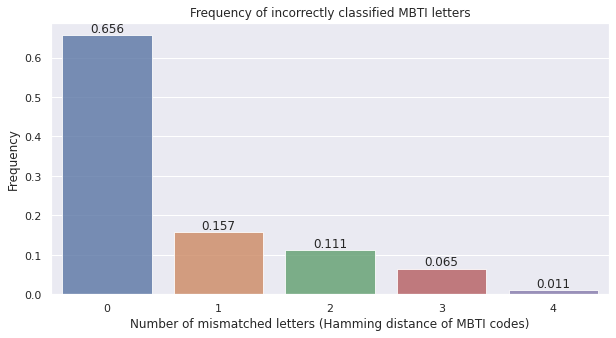

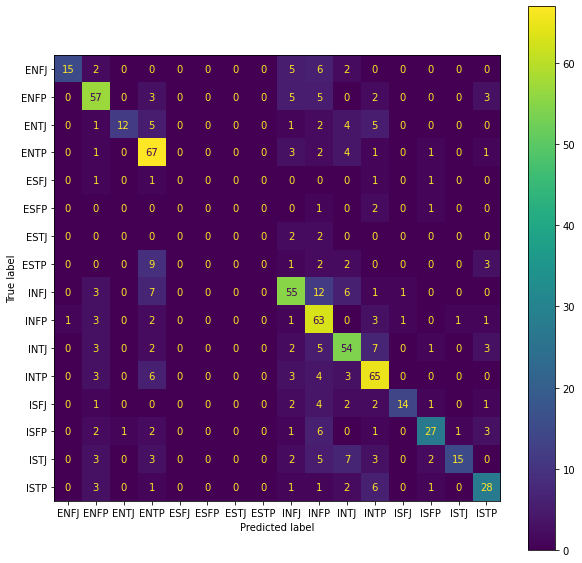

In [19]:
random_forest_pipeline = make_pipeline(
    FunctionTransformer(add_engineered_features),
    make_column_transformer(
        (CountVectorizer(vocabulary=important_words), 'comments_without_links_joined_lower'),
        ('passthrough', continuous_features),
        remainder='drop'),
    RandomForestClassifier(n_estimators=random_forest_n_estimators, max_depth=random_forest_max_depth, min_samples_leaf=random_forest_min_samples_leaf)
)

random_forest_pipeline.fit(MBTI_train_X, MBTI_train_y)

MBTI_pred_y = random_forest_pipeline.predict(MBTI_validation_X)
evaluate_model(MBTI_validation_y, MBTI_pred_y, "micro")

### Naive Bayes

Naive bayes classifies data using Bayes theorem. It finds probability that a person belongs to a class. For us the idea is, that different types of people use different words with some probability.

#### Model interpretation
This model will learn a probability that a person belongs to some class if he says certain words, or how many emojis does he use. Model is less sensitive towards input words that we choose.

#### Model pipeline
* Extract new features using `FunctionTransformer` and `add_engineered_features`
* Discretize continuous attributes using bucketing - NB doesn't work well with continuous features
* Count words in comments using `CountVectorizer`
* Classify the personality with Multinomial Naive Bayes

#### Hyperparameter tuning
All parameter tuning was done by hand. We couldn't use grid search, because the most influential parameter, the vocabulary of the CountVectorizer, is not a part of pipeline and is calculated separately.

Counting every word lead to f1 score of around 0.4 - probably because some words were correlated. Counting too few words lead to similar scores, as they didn't occur in most samples. The best score of around 0.65 was obtained by counting about 1000 words with highest frequency in some personality.

We also tuned the number of buckets in the discretizer and smoothing parameter in Naive Bayes. But compared to the vocabulary, they had very small influence.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument 

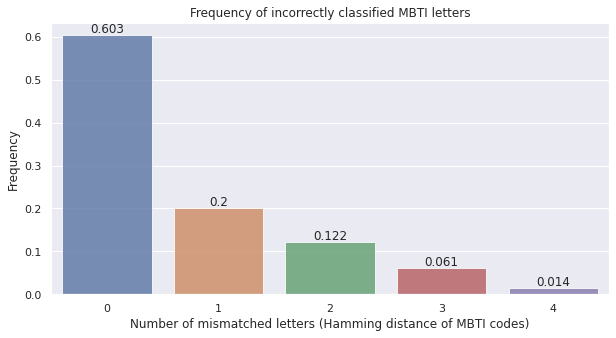

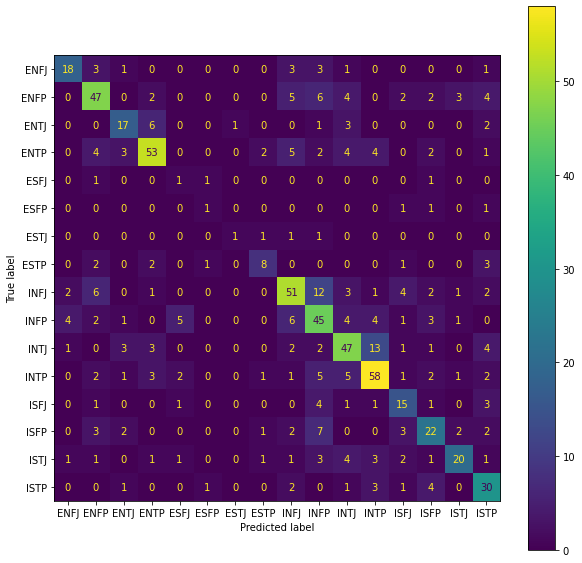

In [20]:
bayes_pipeline = make_pipeline(
    FunctionTransformer(add_engineered_features),
    make_column_transformer(
        (CountVectorizer(vocabulary=important_words), 'comments_without_links_joined_lower'),
        (KBinsDiscretizer(discretizer_bin_count, strategy='quantile'), continuous_features),
        remainder='drop'),
    MultinomialNB())
bayes_pipeline.fit(MBTI_train_X, MBTI_train_y)

MBTI_pred_y = bayes_pipeline.predict(MBTI_validation_X)
evaluate_model(MBTI_validation_y, MBTI_pred_y, "weighted")

## Evaluation

The Random forest classifier seems to perform the best, therefore we have decided to present its abilities in this section. It will be evaluated on the test set, which the trained model hasn't seen yet.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
F1 score: 0.6748057713651499


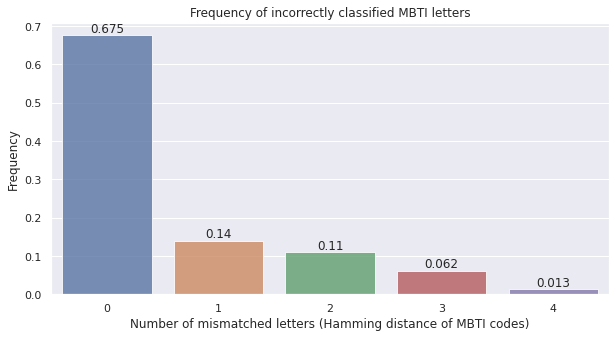

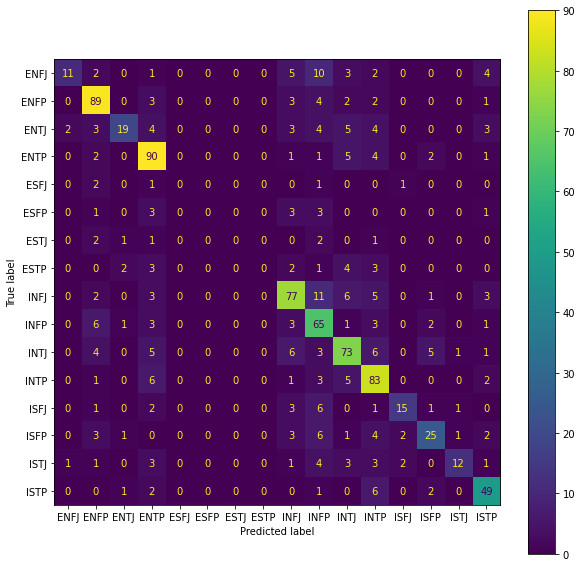

In [21]:
MBTI_pred_y = random_forest_pipeline.predict(MBTI_test_X)
evaluate_model(MBTI_test_y, MBTI_pred_y, "micro")

It reaches F1 score **0.65** on the test set.

We can have a closer look at the 

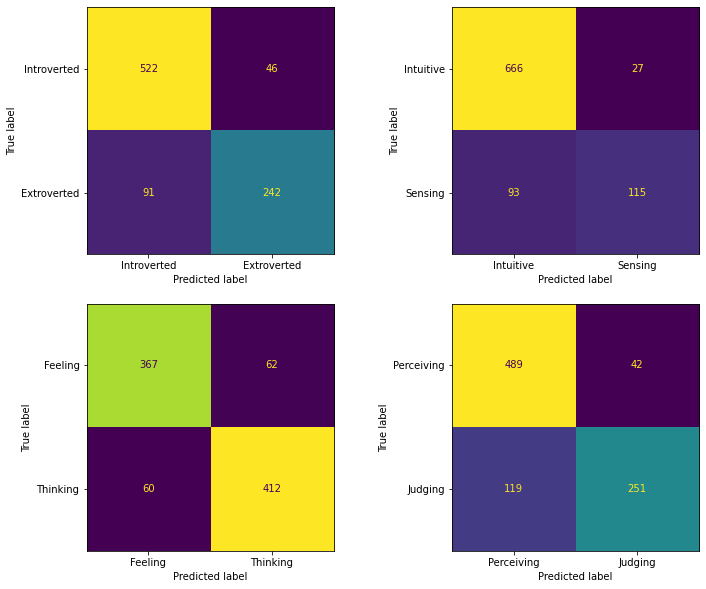

In [22]:
plot_trait_confusion_matrix(MBTI_test_y, MBTI_pred_y)

## Conclusion

#### Model comparison
All of our models are better than the baseline model.

First we have tried the Decision tree model. It works quite well, but it tends to underfit and favor the most represented classes too much. We think that this may be caused by high dimensionality of our data - the model has to choose from about 1000 features.

Then we tried random forests. In theory, they should perform better than decision trees, since they contain multiple decision trees in themselves. The model should also work better on high-dimensionality data, because it trains multiple trees. This turned out to be true. The model has much better score than the decision tree.

Then we have tried the Naive bayes model to see if it would perform better. Although both Random forest and Naive bayes have comparable accuracy and F1-score, we have chosen Random forest model, because it does not have the independecne prerequirement and we think that people use some words together. For example when extroverts talk about partying they usually talk about alcohol, drugs and sex all at once.

#### Impact of non-word features
We tested the impact of features like mean comment length and emoji count on classification accuracy and found out that they contribute roughly by 0.02 to F1 score. The vocabulary of the user tells us much more about their personality.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dcc0a311-60f8-4d72-95f7-a5bb23f8fbc9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>